In [25]:
%matplotlib widget

In [26]:
import xtrack as xt
import numpy as np
import xplt

import matplotlib.pyplot as plt

In [27]:
line = xt.Line()
line.particle_ref = xt.Particles(p0c=2e9)

In [28]:
n_bends_per_cell = 6
n_cells_par_arc = 3
n_arcs = 3

n_bends = n_bends_per_cell * n_cells_par_arc * n_arcs

## Arc cell

In [29]:
line.vars({
    'l.mq': 0.5,
    'l.mb': 11,
    'angle.mb': 2 * np.pi / n_bends,
    'k0.mb': 'angle.mb / l.mb',
    'kqf': 0.05,
    'kqd': -0.051
})

In [30]:
halfcell = line.new_section(components=[
    line.new_element('drift.1', xt.Drift,      length='l.mq / 2'),
    line.new_element('qf',      xt.Quadrupole, k1='kqf', length='l.mq'),
    line.new_element('drift.2', xt.Drift,      length=0.75),
    line.new_element('mb.1',    xt.Bend,       k0='k0.mb', h='k0.mb', length='l.mb'),
    line.new_element('drift.3', xt.Drift,      length=1.),
    line.new_element('mb.2',    xt.Replica,    parent_name='mb.1'),
    line.new_element('drift.4', xt.Drift,      length=1.),
    line.new_element('mb.3',    xt.Replica,    parent_name='mb.1'),
    line.new_element('drift.5', xt.Drift,      length=0.75),
    line.new_element('qd',      xt.Quadrupole, k1='kqd', length='l.mq'),
    line.new_element('drift.6', xt.Replica,    parent_name='drift.1'),
])

In [31]:
hcell_left = halfcell.replicate(name='l')
hcell_right = halfcell.replicate(name='r', mirror=True)

cell = line.new_section(components=[
    line.new_element('start', xt.Marker),
    hcell_left,
    line.new_element('mid', xt.Marker),
    hcell_right,
    line.new_element('end', xt.Marker),
])

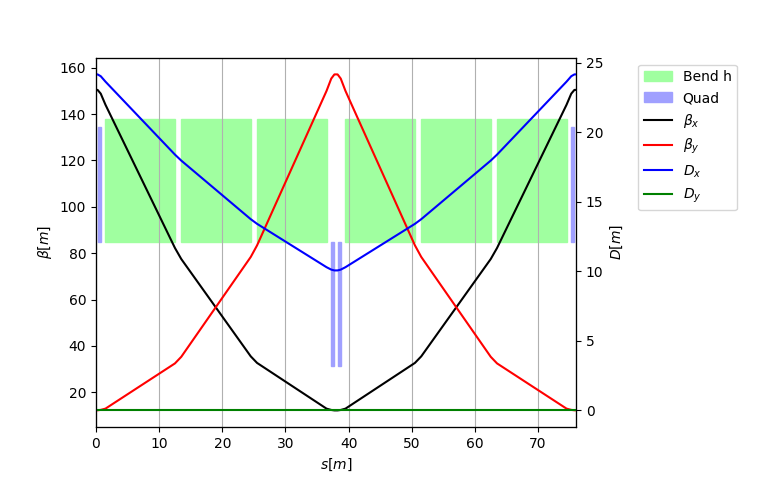

In [42]:
cell.twiss4d().plot()

In [33]:
opt = cell.match(
    method='4d',
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-5),
    targets=xt.TargetSet(
        qx=0.333333,
        qy=0.333333,
    ))
tw_cell = cell.twiss4d()

Matching: model call n. 20               



## Straight section cell

Matching: model call n. 119               



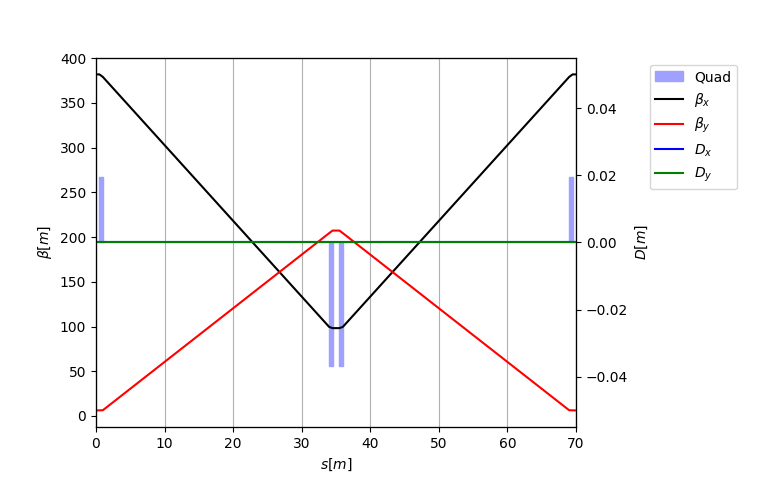

In [34]:
line.vars({
    'k1l.qfss': 0.027 / 2,
    'k1l.qdss': -0.0271 / 2,
    'kqfss.1': 'k1l.qfss / l.mq',
    'kqdss.1': 'k1l.qdss / l.mq',
    'angle.mb': 2 * np.pi / n_bends,
    'k0.mb': 'angle.mb / l.mb',
})
cell_ss = line.new_section(components=[
    line.new_element('ss.start', xt.Marker),
    line.new_element('dd.ss.1.l', xt.Drift,        length='l.mq'),
    line.new_element('qfss.l',    xt.Quadrupole, k1='kqfss.1', length='l.mq'),
    line.new_element('dd.ss.3.l', xt.Drift,        length='3 *l.mb'),
    line.new_element('qdss.l',    xt.Quadrupole, k1='kqdss.1', length='l.mq'),
    line.new_element('dd.ss.5.l', xt.Drift,        length='l.mq'),
    line.new_element('dd.ss.5.r', xt.Drift,        length='l.mq'),
    line.new_element('qdss.r',    xt.Quadrupole, k1='kqdss.1', length='l.mq'),
    line.new_element('dd.ss.3.r', xt.Drift,        length='3 *l.mb'),
    line.new_element('qfss.r',    xt.Quadrupole, k1='kqfss.1', length='l.mq'),
    line.new_element('dd.ss.1.r', xt.Drift,        length='l.mq'),

])

opt = cell_ss.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['k1l.qfss', 'k1l.qdss'], step=1e-5),
    targets=xt.TargetSet(at='ss.start',
        betx=tw_cell.betx[-1],
        bety=tw_cell.bety[-1],
    ))
opt.step(40)
opt.solve()

cell_ss.twiss4d().plot()

## Make an arc

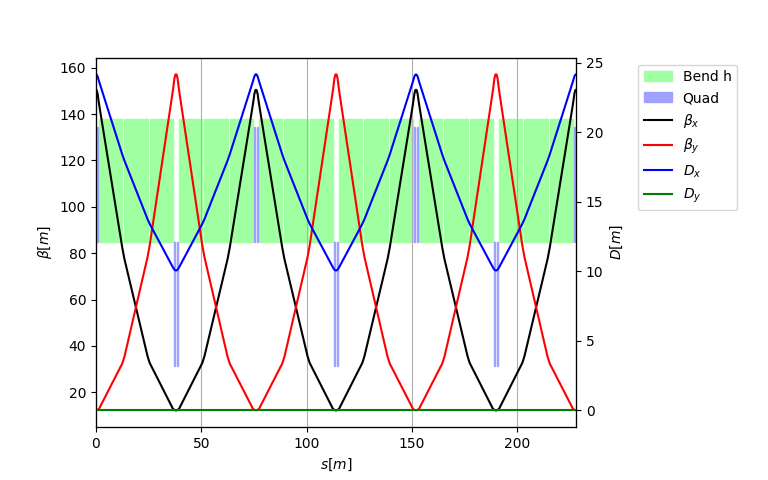

In [35]:
arc = line.new_section(components=[
    cell.replicate(name='cell.1'),
    cell.replicate(name='cell.2'),
    cell.replicate(name='cell.3'),
])
arc.twiss4d().plot()

## Build an straight section

In [36]:
ss = line.new_section(components=[
    cell_ss.replicate('cell.1'),
    cell_ss.replicate('cell.2'),
])

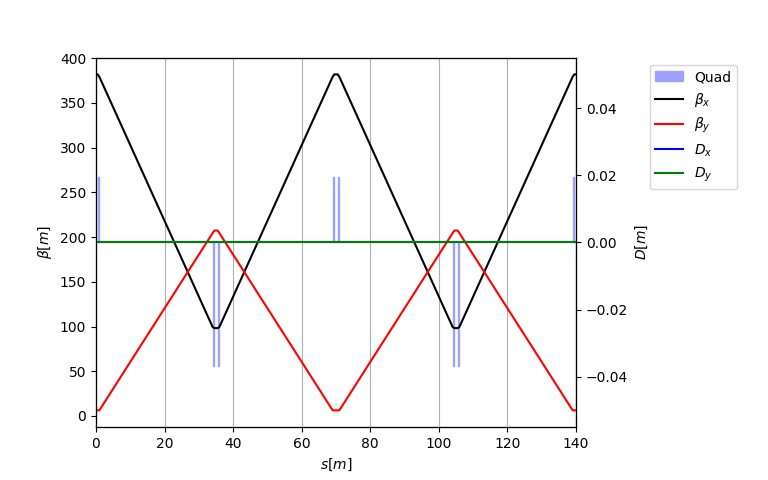

In [41]:
ss.twiss4d().plot()

## Build the ring

In [37]:
line.element_names.clear()
line.append(ss.replicate('ss.1'))
line.append(arc.replicate('arc.1'))
line.append(ss.replicate('ss.2'))
line.append(arc.replicate('arc.2'))
line.append(ss.replicate('ss.3'))
line.append(arc.replicate('arc.3'))

### Remove replicas

In [38]:
line.replace_all_replicas()

## Plot geometry

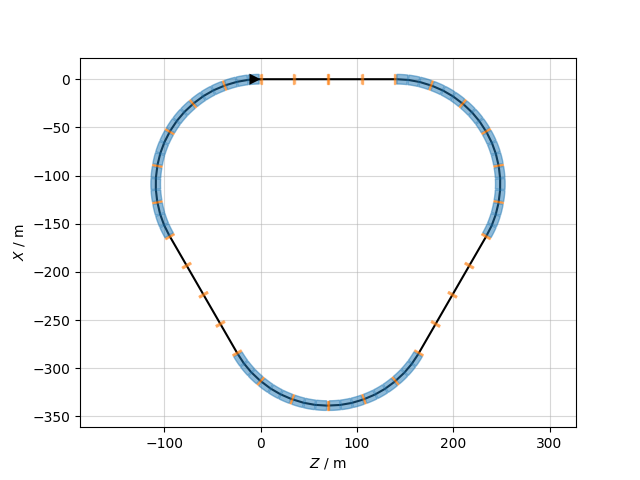

In [39]:
sv = line.survey()
xplt.FloorPlot(sv, line, element_width=10)

### Plot optics

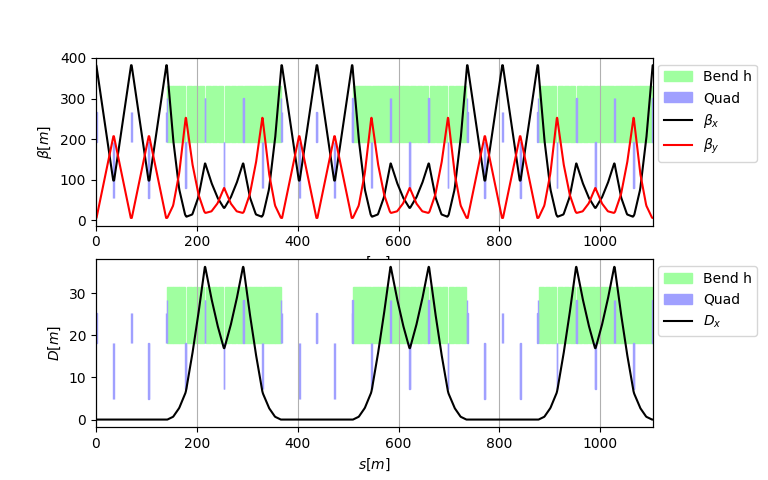

In [40]:
tw = line.twiss4d()
fig = plt.figure(figsize=(6.4*1.2, 4.8))
ax1 = fig.add_subplot(2, 1, 1)
pltbet = tw.plot('betx bety', ax=ax1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
pltdx = tw.plot('dx', ax=ax2)
fig.subplots_adjust(right=.85)
pltbet.move_legend(1.2,1)
pltdx.move_legend(1.2,1)

## Create a straight section with 40 m long free space (with $\beta_x = \beta_y)$ 

### Layout

In [17]:
line.vars({
    'k1.q1': 0.025,
    'k1.q2': -0.025,
    'k1.q3': 0.025,
    'k1.q4': -0.02,
    'k1.q5': 0.025,
})

half_insertion = line.new_section(components=[
    line.new_element('ip', xt.Marker),
    line.new_element('dd.0', xt.Drift, length=20),
    line.new_element('mq.1', xt.Quadrupole, k1='k1.q1', length='l.mq'),
    line.new_element('dd.1', xt.Drift, length=5),
    line.new_element('mq.2', xt.Quadrupole, k1='k1.q2', length='l.mq'),
    line.new_element('dd.2', xt.Drift, length=12),
    line.new_element('mq.3', xt.Quadrupole, k1='k1.q3', length='l.mq'),
    line.new_element('dd.3', xt.Drift, length=18),
    line.new_element('mq.4', xt.Quadrupole, k1='k1.q4', length='l.mq'),
    line.new_element('dd.4', xt.Drift, length=18),
    line.new_element('mq.5', xt.Quadrupole, k1='k1.q5', length='l.mq'),
    line.new_element('dd.5', xt.Drift, length=0.5),
    line.new_element('e.insertion', xt.Marker),
])

### Macth optics to have symmetry, round beta in the center and correct interface to adjacient arc

In [18]:
tw_arc = arc.twiss4d()

opt = half_insertion.match(
    solve=False,
    betx=tw_arc.betx[0], bety=tw_arc.bety[0],
    alfx=tw_arc.alfx[0], alfy=tw_arc.alfy[0],
    init_at='e.insertion',
    start='ip', end='e.insertion',
    vary=xt.VaryList(['k1.q1', 'k1.q2', 'k1.q3', 'k1.q4'], step=1e-5),
    targets=[
        xt.TargetSet(alfx=0, alfy=0, at='ip'),
        xt.Target(lambda tw: tw.betx[0] - tw.bety[0], 0),
        xt.Target(lambda tw: tw.betx.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.bety.max(), xt.LessThan(400)),
        xt.Target(lambda tw: tw.betx.min(), xt.GreaterThan(2)),
        xt.Target(lambda tw: tw.bety.min(), xt.GreaterThan(2)),
    ]
)

opt.solve()

Matching: model call n. 62               



In [19]:
%pdb

Automatic pdb calling has been turned ON


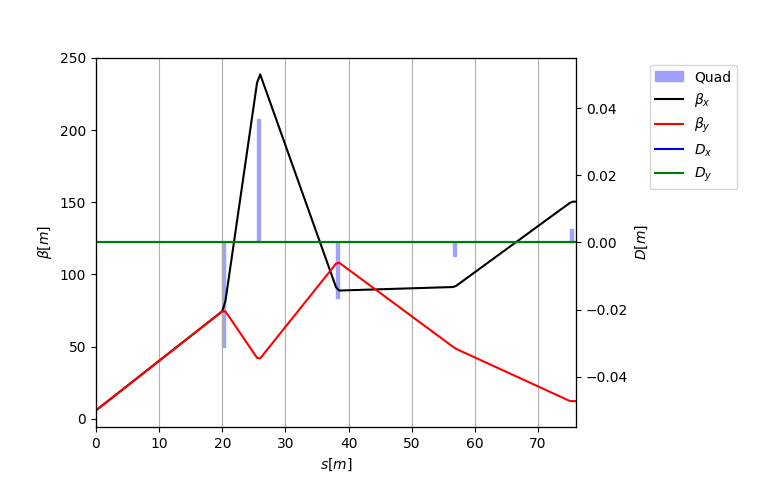

In [20]:
half_insertion.twiss(
    betx=tw_arc.betx[0], bety=tw_arc.bety[0],
    alfx=tw_arc.alfx[0], alfy=tw_arc.alfy[0],
    init_at='e.insertion').plot()

In [21]:
insertion = line.new_section([
    half_insertion.replicate('l', mirror=True),
    half_insertion.replicate('r')])    

In [22]:
line.discard_tracker()

In [23]:
line.element_names.clear()
line.append(ss.replicate('ss.1'))
line.append(arc.replicate('arc.1'))
line.append(insertion)
line.append(arc.replicate('arc.2'))
line.append(ss.replicate('ss.3'))
line.append(arc.replicate('arc.3'))

In [24]:
line.twiss4d().plot()

/Users/giadarol/xsuite_packages/xtrack/xtrack/linear_normal_form.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  n2 = 1./np.sqrt(np.matmul(np.matmul(a2, S), b2))
/Users/giadarol/xsuite_packages/xtrack/xtrack/linear_normal_form.py:190: RuntimeWarning: invalid value encountered in multiply
  a2 *= n2
/Users/giadarol/xsuite_packages/xtrack/xtrack/linear_normal_form.py:194: RuntimeWarning: invalid value encountered in multiply
  b2 *= n2


ValueError: Invalid one-turn map: No coordinates respond to variations of y

> /Users/giadarol/xsuite_packages/xtrack/xtrack/linear_normal_form.py(230)_assert_matrix_responsiveness()
    228         mask_non_zero[ii] = False
    229         if np.sum(mask_non_zero)<1:
--> 230             raise ValueError(
    231                 'Invalid one-turn map: No coordinates respond to variations of '
    232                 + 'x px y py zeta delta'.split()[ii])



ipdb>  q
